Leukemia describes a group of blood disorders characterized by the dysfunctional production and development of lymphocytes, a type of white blood cell.

In this notebook, 2 different models are provided to solve multiclass classification problem on [leukemia gene expression dataset](https://www.kaggle.com/datasets/brunogrisci/leukemia-gene-expression-cumida) from [Curated Microarray Database (CuMiDa)](https://sbcb.inf.ufrgs.br/cumida).

The common challenge in gene expression arrays is that they violate the assumption that the number of samples is higher than the number of predictors (*p >> n*). Therefore, *Naive Bayes Classifier* and *Support Vector Machines* will be used as model algorithms, which perform well on such data most of the time. The dimensionality of the original dataset will be reduced by decomposing it into principal components and keeping the principal components that explain the 90% of the variance. The reduced version of the data will be feeding the Support Vector Classifier. 

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

## Importing and Preprocessing the Data

In [2]:
data = pd.read_csv('./Data/Leukemia_GSE9476.csv')

In [3]:
print(data.shape)
data.head()

(64, 22285)


,samples,type,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Hs28SrRNA-5_at,AFFX-r2-Hs28SrRNA-M_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,1,Bone_Marrow_CD34,7.745245,7.811210,6.477916,8.841506,4.546941,7.957714,5.344999,4.673364,...,5.058849,6.810004,12.800060,12.718612,5.391512,4.666166,3.974759,3.656693,4.160622,4.139249
1,12,Bone_Marrow_CD34,8.087252,7.240673,8.584648,8.983571,4.548934,8.011652,5.579647,4.828184,...,4.436153,6.751471,12.472706,12.333593,5.379738,4.656786,4.188348,3.792535,4.204414,4.122700
2,13,Bone_Marrow_CD34,7.792056,7.549368,11.053504,8.909703,4.549328,8.237099,5.406489,4.615572,...,4.392061,6.086295,12.637384,12.499038,5.316604,4.600566,3.845561,3.635715,4.174199,4.067152
3,14,Bone_Marrow_CD34,7.767265,7.094460,11.816433,8.994654,4.697018,8.283412,5.582195,4.903684,...,4.633334,6.375991,12.903630,12.871454,5.179951,4.641952,3.991634,3.704587,4.149938,3.910150
4,15,Bone_Marrow_CD34,8.010117,7.405281,6.656049,9.050682,4.514986,8.377046,5.493713,4.860754,...,5.305192,6.700453,12.949352,12.782515,5.341689,4.560315,3.887020,3.629853,4.127513,4.004316


In [4]:
data['type'].value_counts()

AML                 26
Bone_Marrow         10
PB                  10
PBSC_CD34           10
Bone_Marrow_CD34     8
Name: type, dtype: int64

In [5]:
# Replacing labels with numeric values
data["type"] = data["type"].replace({"AML":0, "Bone_Marrow":1, "PB":2, "PBSC_CD34":3, "Bone_Marrow_CD34":4})
# Storing label names in a list
labels = ["AML", "Bone_Marrow", "PB", "PBSC_CD34", "Bone_Marrow_CD34"]

### Train-Test Split

In [6]:
X = data.drop(["type"], axis=1)
y = data["type"]
  
# using the train test split function
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=200, test_size=0.30, shuffle=True)

### Principal Component Analysis

In [7]:
pca = PCA()
pca.fit_transform(X_train)

array([[ 7.42136611e+01, -2.18219666e+01, -1.70596309e+01, ...,
         1.69833896e+00,  1.65937536e+00,  1.27173212e-13],
       [ 2.20025774e+01,  4.37665430e+01, -1.27529875e+01, ...,
         8.35724135e-02, -9.58648421e-01,  1.27173212e-13],
       [-8.31658114e+00, -2.42812693e+01, -2.09776274e+01, ...,
        -3.89558842e-01, -8.52854616e-03,  1.27173212e-13],
       ...,
       [ 2.36180585e+01,  3.74960783e+01, -2.36891534e+01, ...,
        -4.22934933e+00,  1.24303529e+01,  1.27173212e-13],
       [-1.60907152e+01, -1.68696788e+01,  1.83121977e+01, ...,
         2.19669798e-01, -1.57023579e-01,  1.27173212e-13],
       [ 4.35651139e+01,  1.13885969e+01,  5.10196868e+01, ...,
        -7.98296444e-02,  2.49958631e-01,  1.27173212e-13]])

19 features explain around 90% of the variance.


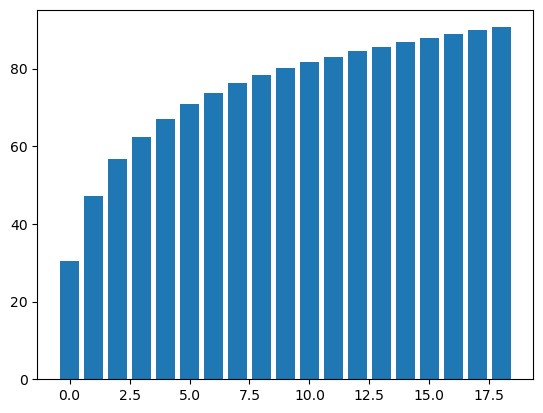

In [8]:
total = sum(pca.explained_variance_)
k = 0
current_variance = 0

while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k = k + 1
    
print(k, " features explain around 90% of the variance.", sep='')

pca = PCA(n_components=k)
X_train.pca = pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

var_exp = pca.explained_variance_ratio_.cumsum()
var_exp = var_exp*100
plt.bar(range(k), var_exp);

In [9]:
pca_2 = PCA(n_components=2).fit(X_train)
X_train_reduced = pca_2.transform(X_train)

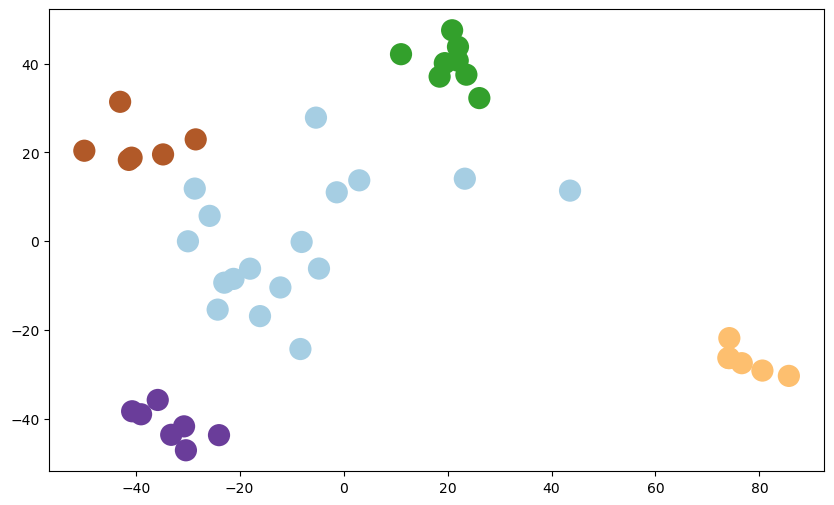

In [10]:
fig = plt.figure(1, figsize = (10, 6))
plt.scatter(X_train_reduced[:, 0],  X_train_reduced[:, 1], c = y_train, cmap = plt.cm.Paired, linewidths=10)

Clusters can be seen clearly when the data is reduced to 2D.

## Modeling

### Baseline

Firstly, the accuracy score of simply predicting each test observation as the dominating class, which is acute myeloid leukemia (AML) in this case, can be checked as a baseline.

In [14]:
base_acc = len(y_test[y_test == 0])/len(y_test)*100
print("Baseline Accuracy ", round(base_acc, 3), "%", sep = '')

Baseline Accuracy 45.0%


### Naive Bayes Classifier

Naive Bayes Accuracy: 95.0%


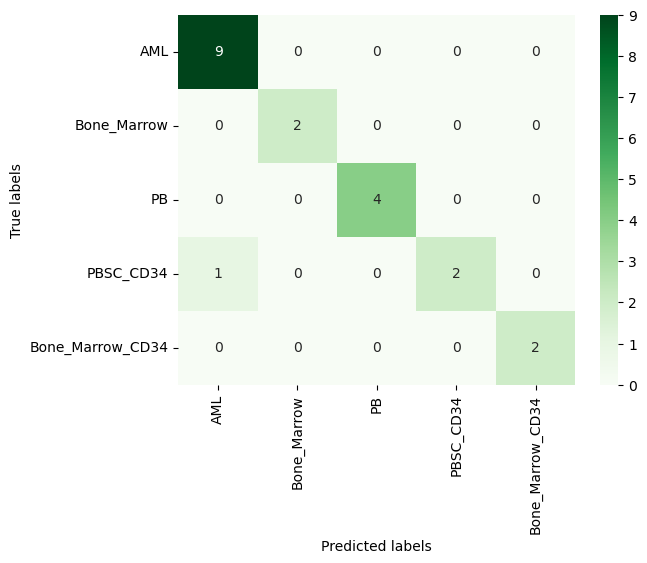

In [12]:
# Model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Prediction
nb_pred = nb_model.predict(X_test)

# Accuracy
nb_acc = accuracy_score(y_test, nb_pred)*100
print('Naive Bayes Accuracy: ', round(nb_acc, 3), "%", sep="")

# Confusion Matrix
cm_nb = confusion_matrix(y_test, nb_pred)

# Plot
ax = plt.subplot()
sns.heatmap(cm_nb, annot=True, ax=ax, fmt='g', cmap='Greens') 

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(labels, rotation=90) 
ax.yaxis.set_ticklabels(labels, rotation=360);

### Support Vector Machines

Best Parameters:
 {'C': 10, 'decision_function_shape': 'ovo', 'gamma': 1e-05, 'kernel': 'rbf'}
SVM Accuracy: 100.0%


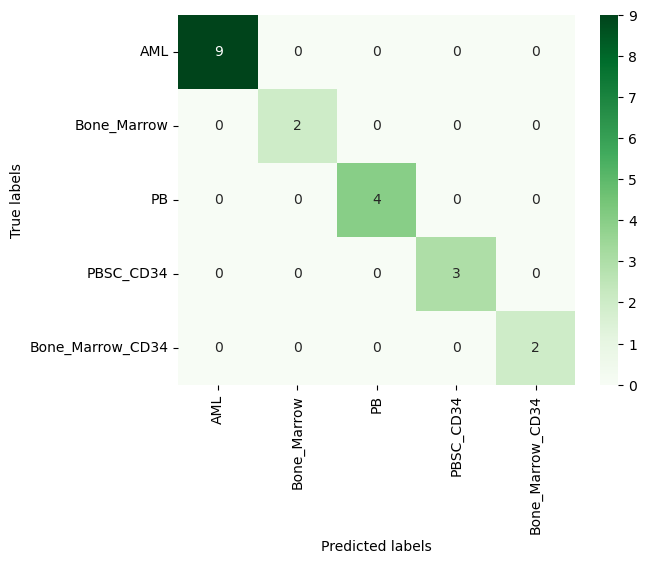

In [13]:
# Parameter grid
svm_param_grid = {  'C': [0.1, 1, 10, 100],
                    "decision_function_shape" : ["ovo", "ovr"],
                    'gamma': [1, 0.1, 0.01, 0.001, 0.00001, 10],
                    "kernel": ["linear", "rbf", "poly"]} 

# Creating the SVM grid search classifier
svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=3)

# Training the classifier
svm_grid.fit(X_train_pca, y_train)

print("Best Parameters:\n", svm_grid.best_params_)

# Selecting the best SVC
best_svc = svm_grid.best_estimator_

# Predictions
svm_pred = best_svc.predict(X_test_pca)

# Accuracy
svc_acc = accuracy_score(y_test, svm_pred)*100
print('SVM Accuracy: ', round(svc_acc, 3), "%", sep="")

cm_svm = confusion_matrix(y_test, svm_pred)

ax = plt.subplot()
sns.heatmap(cm_svm, annot=True, ax = ax, fmt='g', cmap='Greens') 

# Labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(labels, rotation=90) 
ax.yaxis.set_ticklabels(labels, rotation=360);

As can be seen from the confusion matrices, both models perform well. If a larger part of the dataset (i.e. 75%) were used as training data, Naive Bayes would also reach to perfect classification.

Note that the models might not perform as well as this case on different datasets or might require further configurations, since the dataset used in this notebook is extremely clean.

Inspired by: [Gene Expression Classification](https://www.kaggle.com/code/varimp/gene-expression-classification)